# COPDGene2 Fagerstrom Test For Nicotine Dependence (FTND) GWAS
__Author:__ Jesse Marks

See [GitHub Issue #78](emerge_ea.1000G.CAT_FTND~SNP+SEX+EVs.maf_gt_0.01_rsq_gt_0.30_ea.snps+indels.manhattan.png.gz)

This document logs the steps taken to process:

* `Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute` data and perform the FTND GWAS. The [COPDGene](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000179.v1.p1) cohort is racially diverse and sufficiently large and appropriately designed for genome-wide association analysis of COPD. 

* There are 10K subjects including control smokers, definite COPD cases (GOLD Stage 2 to 4) and subjects not included in either group (GOLD 1 or GOLD-Unclassified). 

* The focus of this study is genome-wide association analysis to identify the genetic risk factors that determine susceptibility for COPD and COPD-related phenotypes.

* Our phenotype of interest is FTND

FTND is a standard instrument for assessing the physical addiction to nicotine. For more information, see [this website](https://cde.drugabuse.gov/instrument/d7c0b0f5-b865-e4de-e040-bb89ad43202b).

The imputed genotype are stored on Amazon Web Services S3 at:

`s3://rti-nd/COPDGene`

* **Note**: I will first perform the GWAS with only the autosomes 

* John Guo would like me to try this with the Nextflow pipeline


## Notes about study
**Note**: these notes are not cohesive but serve as a personal reference for information I gathered on the study

* we have 1000 Genomes phase 3 imputation already available on the full COPDGene dataset

* we will run COPDGene1 and COPDGene2 separately because FTND was collected several years apart and there were some key differences in the way that the questions were asked in the different waves. We will keep the two waves separate to circumvent any potential discrepancies which could arrise because of the phenotypes being less than harmonious and then we will combine them in a meta-analysis later. 


* I will run the GWAS analysis with the following variables:

**COPDGene2** (all data from phase 2 LFU dataset, except for gender and finalGOLD which was collected only in phase 1)
The criteria for COPDGene2 are:

```1) WstFTND_cat_p2 (mostly former smokers with some current smokers picked up)
2) age_p1 (age at current visit)
3) gender (1=male, 2=female)
4) Goldneg1 (between case and control - exhibits signs of both. Failed one diagnostic test while passing another.)
5) Gold1or2 (cases)
6) Gold3or4 (severe cases)
7) EVs to be selected```

**Also, I need to split the data up by race** (1=white, 2=black) 


**Note** We cannot assume that the increments in the GOLD classification are equal which is why we need to embed dummy variables rather than a single categorical variable in our regression models.

* GOLD stands for the Global Initiative for Chronic Obstructive Lung Disease. Essentially, GOLD it is a metric for quantifying the severity of COPD a patient has.

* FTND outcome and covariates are now ready at the path:
    
    `\\rcdcollaboration01.rti.ns\GxG\Analysis\COPDGene\phenotypes\Phase2\COPD Both waves with Cat FTND_v2.xls`
    

* For COPDGene1, we are increasing the sample size by several hundred. This is because, the previous analysis of COPDGene1 included only the subjects with determinant COPD GOLD status (finalGold=0 for controls, 1/2 for cases, and 3/4 for severe cases.) Now we know that subjects with an indeterminant status (i.e. finalGold=-1) were subjects that were classified to be between case and control. With this newfound knowledge, we can go ahead and include these subjects and rerun COPDGene1 with these subjects plus the subjects that were in the previous analysis. The model will be:

`CurFTND_cat_p1 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`
    * Also note that in this phase1, the subjects were all current smokers. (max N=5289)

* For phase2, COPDGene2, we need to exclude all of the subjects which were included in COPDGene1. This will leave *mostly* former smokers with lifetime FTND reported (max N=2934). There will be some current smokers picked up in phase2 and we will include them here.

`WstFTND_cat_p2 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`


* So, 2,934 is the maximum number of subjects that will be included in COPDGene2. We will have to filter this down based on if the subjects have `sex, age, GOLD status,` and `genotype data.` Also, there are reportedly 4 subjects for COPDGene2 (have entries for the WstFTND_cat_p2 variable) that are missing finalGold status. Of those 4, 3 marked 0 for `Goldneg1`, `Gold1or2`, or `Gold3or4` and the other 1 has NA for those three variables. We will treat these 4 subjects as missing and exclude them from the analysis.

### WstFTND_cat_p2 variable description
| cat | Freq |
|-----|------|
| 0   | 1,122 |   
| 1   | 1,286 |   
| 2   | 526   |   

* Where FTND conversion is 0=0-3, 1=4-6, and 2=7+

## Capturing missing subjects

There are two age variables of interest for this COPDGene2 study. One is `age_p1` and the other is `age_p2`. We would like to use the latest data, which is `age_p2` but there are 195 subjects that don't have this data. In the subjection titled "Impute missing age", we propose method which imputes from the `age_p1` data to estimate the missing `age_p2` data. In essence, we will create a new age variable `age_p3` which will allow us to incorporate those subjects that would have been lost if we had just went with the COPDGene2 subjects having `age_p2` data. 

**`age_p3` description **
* if a subject has `age_p2` data, then their `age_p3` is set equal to their `age_p2`
* if the subject is missing `age_p2` data, then impute from their `age_p1`
    * the data will be imputed by adding the average difference between `age_p2` and `age_p1` of the COPDGene2 subjects that have both `age_p1` and `age_p2` data. The average will be either the median or mean - this will be determined upon further discussion.
    
See section [missing subjects](#missing_subs) for details of this subject age imputation process.

# Prepare files for ProbABEL
## Phenotype Data COPDGene2
**Age p1 filtered table**

| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (WstFTND & !CurFTND) | 7,366             | 2,934 |
| Missing finalgold status              | 4                 | 2,930 |
| Missing sex                           | 0                 | 2,930 |
| Missing age (p1)                      | 0                 | 2,930 |
| Missing Genotype                      | 33                | 2,897 |

* Number of EAs: 2,630
* Number of AAs: 267

**Age p2 filtered table**

| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (WstFTND & !CurFTND) | 7,366             | 2,934 |
| Missing finalgold status              | 4                 | 2,930 |
| Missing sex                           | 0                 | 2,930 |
| Missing age (p2)                      | 195               | 2,735 |
| Missing Genotype                      | 32                | 2,703 |

* Number of EAs: 2,470
* Number of AAs: 233

### Apply Filters

In [1]:
pheno.data <- read.table("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/Copy of COPD Both waves with Cat FTND_v2.csv",
                        sep=",", header=T)
print("Below is the table head of the entire phenotype file.")
head(pheno.data)

[1] "Below is the table head of the entire phenotype file."


sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
15814W,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16032X,1,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16126G,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16281S,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16303C,1,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16311B,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA


#### Initial numbers

In [2]:
# COPDGene1
# Calculate number of subjects with CurFTND data
cur.ftnd.vec <-  which(pheno.data$CurFTND_cat_p1 >= 0)
#print("Max number of subjects for COPDGene1 (both ancestries)")
#length(cur.ftnd.vec)


#-----------------------------------------------------------------------------
# COPDGene2
# Calculate the number of subjects with WstFTND data but not CurFTND data

# The indices in cur.ftnd.vec at which the subjects have both wstFTND and CurFTND data
overlap1 <- which(pheno.data$WstFTND_cat_p2[cur.ftnd.vec] >= 0)

# This gives the subject indices which have both wst and cur data
wst.cur.overlap.vec <- cur.ftnd.vec[overlap1]

# Indices of all the subjects with WstFTND data
all.wst <- which(pheno.data$WstFTND_cat_p2 >= 0)

# Subjects that have WstFTND data and no CurFTND data
wst.ftnd.vec <- setdiff(all.wst, wst.cur.overlap.vec) 

print("Max number of subjects for COPDGene2 (both ancestries)")
# calculate subjects that are exclusively WstFTND (subtract those that have both Cur and Wst)
length(wst.ftnd.vec)

# Categorical FTND summary
print("Categorical FTND summary")
table(pheno.data$WstFTND_cat_p2[wst.ftnd.vec])

wst.ftnd.data <- pheno.data[wst.ftnd.vec,]
print("Below is the table head of the COPDGene2 data before any filters (save FTND) have been applied.")
head(wst.ftnd.data)

[1] "Max number of subjects for COPDGene2 (both ancestries)"


[1] 2934

[1] "Categorical FTND summary"



   0    1    2 
1122 1286  526 

[1] "Below is the table head of the COPDGene2 data before any filters (save FTND) have been applied."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,2,NA,-1,73.8,79.1,LFU,9,NA,2,1,1,0,0
105,10260G,1,1,2,NA,-1,68.4,73.9,LFU,5,NA,1,1,1,0,0
107,10489M,2,1,2,NA,-1,60.0,65.8,LFU,4,NA,1,1,1,0,0
108,10511F,2,1,2,NA,-1,80.6,87.4,LFU,3,NA,0,1,1,0,0
110,10558F,1,1,2,NA,-1,60.9,66.8,LFU,5,NA,1,1,1,0,0
118,10771F,1,1,2,NA,-1,69.9,75.6,LFU,3,NA,0,1,1,0,0


#### Missing finalgold filter
Remove subjects missing `finalgold` variable

In [3]:
# some subjects with reported GOLD status are missing in the finalgold variable
gold.data <- wst.ftnd.data$finalgold[]
print("These are the sequential indices in the wst.ftnd.data at which they occur.")
which(is.na(gold.data))
print("Number of subjects missing finalgold.")
length(which(is.na(gold.data)))

print("Here are the data of those subjects with missing finalgold.")
wst.ftnd.data[which(is.na(gold.data)),]

# exclude those subjects with missing finalgold
wst.ftnd.fg.filtered <- wst.ftnd.data[-which(is.na(gold.data)),]

print("Number of subjects remaining after filtering by missing finalgold data.")
length(wst.ftnd.fg.filtered[,1])

[1] "These are the sequential indices in the wst.ftnd.data at which they occur."


[1] 2659 2660 2661 2934

[1] "Number of subjects missing finalgold."


[1] 4

[1] "Here are the data of those subjects with missing finalgold."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
6865,10126C,2,1,2,NA,NA,72.0,77.7,LFU,2,NA,0,NA,0,0,0
6873,15118C,1,1,2,NA,NA,70.7,76.2,LFU,7,NA,2,NA,0,0,0
6884,25119K,1,1,2,NA,NA,74.9,80.2,LFU,1,NA,0,NA,0,0,0
10297,25532S,1,2,2,NA,NA,63.5,68.8,LFU,5,NA,1,NA,NA,NA,NA


[1] "Number of subjects remaining after filtering by missing finalgold data."


[1] 2930

#### Missing Sex filter
Remove any subjects missing sex data.

In [4]:
# filtered out any subjects missing sex data
wst.ftnd.fg.sex.filtered <- wst.ftnd.fg.filtered[complete.cases(wst.ftnd.fg.filtered[, "gender"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, and sex filtering.")
length(wst.ftnd.fg.sex.filtered[,1])

[1] "Number of COPDGene2 subjects after FTND, finalgold, and sex filtering."


[1] 2930

**Note:** no subjects missing sex data. 

#### Missing Age filter
Remove any subjects missing age data. 

**Note**: the filter we ultimately end up using is the imputed variable `age_p3`.

##### age_p1
Filter by variable `age_p1` then write to file.

In [5]:
wst.ftnd.fg.sex.age1.filter <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered[,"age_p1"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p1) filtering.")
length(wst.ftnd.fg.sex.age1.filter[,1])

variables.of.interest1 <- c("sid", "gender", "race", "age_p1", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
pheno1 <- wst.ftnd.fg.sex.age1.filter[,variables.of.interest1]

print("Head of filtered data (age_p1).")
head(pheno1)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno1, "phenotype.ftnd.fg.sex.age1.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p1) filtering."


[1] 2930

[1] "Head of filtered data (age_p1)."


,sid,gender,race,age_p1,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,73.8,2,1,0,0
105,10260G,1,1,68.4,1,1,0,0
107,10489M,2,1,60.0,1,1,0,0
108,10511F,2,1,80.6,0,1,0,0
110,10558F,1,1,60.9,1,1,0,0
118,10771F,1,1,69.9,0,1,0,0


##### age_p2

Filter by variable `age_p2` then write to file.

In [6]:
wst.ftnd.fg.sex.age2.filter <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered[,"age_p2"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p2) filtering.")
length(wst.ftnd.fg.sex.age2.filter[,1])

variables.of.interest2 <- c("sid", "gender", "race", "age_p2", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
pheno2 <- wst.ftnd.fg.sex.age2.filter[,variables.of.interest2]

print("Head of filtered data (age_p2).")
head(pheno2)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno2, "phenotype.ftnd.fg.sex.age2.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p2) filtering."


[1] 2735

[1] "Head of filtered data (age_p2)."


,sid,gender,race,age_p2,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,79.1,2,1,0,0
105,10260G,1,1,73.9,1,1,0,0
107,10489M,2,1,65.8,1,1,0,0
108,10511F,2,1,87.4,0,1,0,0
110,10558F,1,1,66.8,1,1,0,0
118,10771F,1,1,75.6,0,1,0,0


##### Impute missing age `age_p3`
Going to impute the missing age data for the subjects that have missing `age_p2` data. We will do this by creating a third variable `age_p3` which finds the median (or mean) of the age difference between the subjects that have data at both `age_p1` and `age_p2`. I will add the median (or mean) of this age difference to `age_p1` to produce the new entry for `age_p3` for the subjects that have missing `age_p2` data. If the subject is not missing `age_p2`, then the value of `age_p3` for that subject will just be the value given at `age_p2`.

<a id='missing_subs'></a>

[1] "Head of table for data pre-age filtered."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,2,NA,-1,73.8,79.1,LFU,9,NA,2,1,1,0,0
105,10260G,1,1,2,NA,-1,68.4,73.9,LFU,5,NA,1,1,1,0,0
107,10489M,2,1,2,NA,-1,60.0,65.8,LFU,4,NA,1,1,1,0,0
108,10511F,2,1,2,NA,-1,80.6,87.4,LFU,3,NA,0,1,1,0,0
110,10558F,1,1,2,NA,-1,60.9,66.8,LFU,5,NA,1,1,1,0,0
118,10771F,1,1,2,NA,-1,69.9,75.6,LFU,3,NA,0,1,1,0,0


The mean age difference of age_p2 and age_p1 of COPDGene2 subjects is:  5.604552
The median age difference of age_p2 and age_p1 of COPDGene2 subjects is:  5.400002

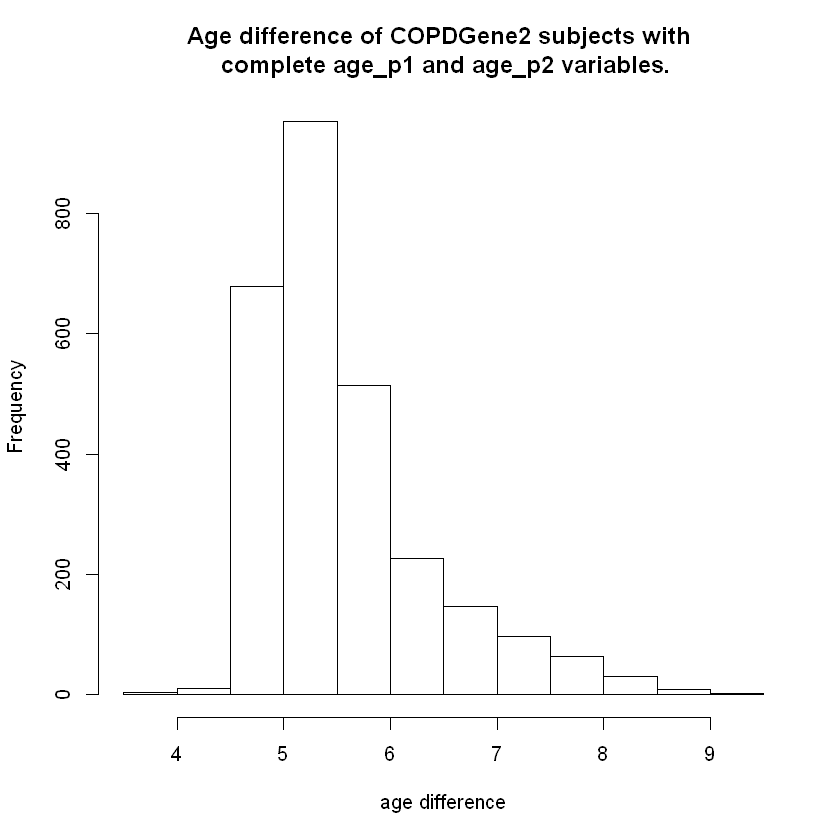

In [7]:
# COPDGene2 subjects pre-age filtering
print("Head of table for data pre-age filtered.")
#head(wst.ftnd.fg.sex.filtered)

age_intersect_df <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered$age_p1, wst.ftnd.fg.sex.filtered$age_p2),]
age_p3 <- wst.ftnd.fg.sex.filtered$age_p2 - wst.ftnd.fg.sex.filtered$age_p1
head(age_intersect_df)

mean_age_dif <- mean(age_intersect_df$age_p2 - age_intersect_df$age_p1)
cat("The mean age difference of age_p2 and age_p1 of COPDGene2 subjects is: " , mean_age_dif)

median_age_dif <- median(age_intersect_df$age_p2 - age_intersect_df$age_p1)
cat("\n")
cat("The median age difference of age_p2 and age_p1 of COPDGene2 subjects is: " , median_age_dif)

# get a distribution of the age 
hist(age_p3, main = "Age difference of COPDGene2 subjects with \n complete age_p1 and age_p2 variables.",
    xlab = "age difference")
# add the third variable age_p3 in the dataframe.

In [49]:
library(tibble)

wst.ftnd.fg.sex.age3.filtered <- add_column(wst.ftnd.fg.sex.filtered, age_p3 =wst.ftnd.fg.sex.filtered$age_p2 , .after = 8)

# replace NA values in age_p3 with the value from age_p1 + median_age_dif (between age_p2 and age_p1)
for(i in 1:nrow(wst.ftnd.fg.sex.age3.filtered)){
    if (is.na(wst.ftnd.fg.sex.age3.filtered[i, "age_p3"])){
        wst.ftnd.fg.sex.age3.filtered[i, "age_p3"] <- wst.ftnd.fg.sex.age3.filtered[i, "age_p1"] + median_age_dif
    }
}
#length(wst.ftnd.fg.sex.age3.filtered[,1])

variables.of.interest3 <- c("sid", "gender", "race", "age_p3", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
wst.ftnd.fg.sex.age3.filtered <- wst.ftnd.fg.sex.age3.filtered[, variables.of.interest3]

head(wst.ftnd.fg.sex.age3.filtered)
# next I need to subset this dataframe to only the columns of interest and then save it to file

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno1, "phenotype.ftnd.fg.sex.age3.filtered.txt", sep = " ", row.names = F, quote = F)

,sid,gender,race,age_p3,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,79.1,2,1,0,0
105,10260G,1,1,73.9,1,1,0,0
107,10489M,2,1,65.8,1,1,0,0
108,10511F,2,1,87.4,0,1,0,0
110,10558F,1,1,66.8,1,1,0,0
118,10771F,1,1,75.6,0,1,0,0


#### Genotype filter V1

Construct subject-filtered PLINK file sets by filterine out subjects missing genotype data.

* This version is when we were testing the two datasets, one that include `age_p1` and the other that included `age_p2`
* See the section below [genotype filter V2](#geno2) for the filtering that was ultimately used which was on the phenotype data that included the newly created variable `age_p3`

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two

# create directory structure on MIDAS
mkdir -p /share/nas03/jmarks/studies/copdgene2/{eigenstrat,data/{assoc_tests,genotype/{observed,imputed},phenotype}}

# copy phenotype data over to MIDAS
#scp phenotype.ftnd.fg.sex.age1.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/
#scp phenotype.ftnd.fg.sex.age2.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/
scp phenotype.ftnd.fg.sex.age3.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/

In [ ]:
## MIDAS console ##
cd /share/nas03/jmarks/studies/copdgene2/data/

cp /share/nas03/bioinformatics_group/data/studies/copdgene/observed/final_filtered/gxg_qc/copdgene.{aa,ea}.{fam,bim,bed} \
    genotype/observed

## create a new PLINK fam file based on subjects with phenotype and genotype data
### age_p1 filter
#### EA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
#    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype1.all.filters.txt
#     
#### AA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
#    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype1.all.filters.txt
#     
#
### age_p2 filter
#### EA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt\
#    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype2.all.filters.txt
#     
#### AA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt \
#    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype2.all.filters.txt
#     

#### Genotype filter V02
Construct subject-filtered PLINK file sets by filtering out subjects missing genotype data.

<a id='geno2'></a>

In [ ]:
## MIDAS console ##
cd /share/nas03/jmarks/studies/copdgene2/data/

# create a new PLINK fam file based on subjects with phenotype and genotype data
## age_p1 filter
### EA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age3.filtered.txt \
    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype3.all.filters.fam
     
### AA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age3.filtered.txt \
    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype3.all.filters.fam



### PCA (EIGENSTRAT)

To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. 


#### Construct subject-filtered PLINK file sets

In [ ]:
## MIDAS ##
cd /shared/s3/copdgene2/data/phenotype

# generate ID list to filter data with

#awk ' NR>=1 { print $1,$1 }' aa.phenotype3.all.filters.fam > id_list.aa.txt
#awk ' NR>=1 { print $1,$1 }' ea.phenotype3.all.filters.fam > id_list.ea.txt
awk ' NR>=2 { print $1,$1 }' phenotype.ftnd.fg.sex.age3.filtered.txt > id_list.txt


# Remove subjects by phenotype criteria
## EA & AA
base_dir=/shared/s3/copdgene2
for ancestry in {"ea","aa"}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${base_dir}/data/genotype/observed/copdgene.${ancestry} \
        --keep id_list.${ancestry}.txt \
        --make-bed \
        --out ${base_dir}/eigenstrat/${ancestry}_pheno_filter
done

for ancestry in {aa,ea}; do
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${base_dir}/data/genotype/observed/copdgene.${ancestry} \
        --keep id_list.txt \
        --make-bed \
        --out ${base_dir}/eigenstrat/${ancestry}_pheno_filter
done

wc -l ${base_dir}/eigenstrat/*.fam
"""
 267 aa_pheno_filter.fam
 2630 ea_pheno_filter.fam
 2897 total
"""

**note:** that it is not necessary to create the `id_list` with the all filters (including
 genotype filter) data set. I can simply create an `id_list` with the fileset that
 includes all of the filters applied except the genotype filter. I don't need an `id_list` with
 the genotype filter applied because if the subjects are not in the genotype file they will not be included 
 once I apply the PLINK filter command anyways. 

#### Remove high-LD region variants

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat

# Remove high-LD region variants
for ancestry in {"ea","aa"}; do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${ancestry}_pheno_filter.bim \
        > ${ancestry}.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_pheno_filter \
        --exclude ${ancestry}.high_ld_regions.remove \
        --make-bed \
        --out ${ancestry}_pheno_filter_high_ld_regions_removed
done

wc -l *.bim
"""
  674935 aa_pheno_filter.bim
  665179 aa_pheno_filter_high_ld_regions_removed.bim
  622168 ea_pheno_filter.bim
  612893 ea_pheno_filter_high_ld_regions_removed.bim
 2575175 total
"""

#### Linkage disequilibrium pruning¶
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are independent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.` 

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat

# Remove high-LD region variants
for ancestry in {"ea","aa"}; do
    # Run per chromosome LD pruning for each chr
    for chr in {1..23}; do
        sh /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${ancestry}_${chr}_ld_prune \
            --script_prefix ${ancestry}_${chr}_ld_prune \
            --mem 3.5 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3500 \
                --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out ${ancestry}_chr${chr}_ld_pruned
    done
done

# Note, make sure to wait until the above jobs have been completed
#Create LD pruned PLINK file sets
for ancestry in {"ea","aa"}; do
    # Merge *prune.in files
    cat ${ancestry}_chr*_ld_pruned.prune.in > ${ancestry}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile ${ancestry}_pheno_filter_high_ld_regions_removed \
        --extract ${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out ${ancestry}_ld_pruned
done

# Clean up
rm *ld_pruned.{prune.in,prune.out,log}
rm *qsub*
rm *high_ld_regions*
rm *nosex
rm *pheno_filter*

wc -l *.bim
"""
219907 aa_ld_pruned.bim
110055 ea_ld_pruned.bim
329962 total
"""

#### Rename BIM/FAM file IDs
BIM and FAM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values if needed.

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat

# Count ID lengths greater than 39 characters
ancestry="ea"
for ancestry in {"ea","aa"}; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' ${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' ${ancestry}_ld_pruned.bim | wc -l
done

"""
======== ea ========


0
0


======== aa ========


0
0
"""

# Rename BIM file IDs
# Make new BIM
#awk '{$2="ID_"NR; print $0}' ${ancestry}_ld_pruned.bim \
#    > ${ancestry}_ld_pruned_id_renamed.bim

# Rename FAM file IDs
# Make new FAM
#awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam \
#   > ${ancestry}_ld_pruned_id_renamed.fam

**Note**: based on these results, we will not rename the `bim` or `fam` files for either ancestry.
**Also**: These data are have not been renamed to the 1000 Genomes Phase 3 format.

#### Remove Case-Control Status from .fam file
We need to remove the case-control status in the last column of the `.fam` file. Some of the subjects have a 1, 2, or -9. When running `smartpca` because all of the subjects do not have a 1 or 2, which signifies case or control, then the subjects with a -9 entry will be assumed to be missing data and they will be removed from the outcome. To remedy this we will set all of the subjects to have -9 and then they will not be excluded from the outcome since none of the subjects have case-control status.

The log file should say something like: 
`all individuals set ignore.  Likely input problem (col 6)
resetting all individual...
`

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat

awk '{$6 = -9; print $0}' aa_ld_pruned.fam > aa_ld_pruned_final.fam
awk '{$6 = -9; print $0}' ea_ld_pruned.fam > ea_ld_pruned_final.fam

#### Run EIGENSTRAT
**NOTE**: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/ # Add EIGENSOFT bin to path

The smartpca.pl program documentation is shown below:

DOCUMENTATION of smartpca.pl program:

This program calls the smartpca program (see ../POPGEN/README). For this to work, the bin directory containing smartpca MUST be in your path. See ./example.perl for a toy example.

../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat

mkdir results

for ancestry in {"ea","aa"};do
    # Run EIGENSTRAT smartpca 
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_smartpca \
        --script_prefix results/smartpca_${ancestry} \
        --mem 13.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i ${ancestry}_ld_pruned.bed \
            -a ${ancestry}_ld_pruned.bim \
            -b ${ancestry}_ld_pruned_final.fam \
            -o results/${ancestry}_ld_pruned.pca \
            -p results/${ancestry}_ld_pruned.plot \
            -e results/${ancestry}_ld_pruned.eval \
            -l results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### View PCs from EIGENSTRAT

In [ ]:
## local machine ##
# Copy results over to local machine so we can visualize the results.
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene2/eigenstrat/results/ea_ld_pruned.pca.evec \
    /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene2/eigenstrat/results/aa_ld_pruned.pca.evec \
    /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat

In [3]:
## R console ##
# Load PCA data
setwd(dir = "C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat/")
options(stringsAsFactors=F)
ea.evec <- read.table("ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
aa.evec <- read.table("aa_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
print("Number of EA subjects and PCA table")
length(ea.evec[,11])
ea.evec[1:5,]
print("Number of AA subjects and PCA table")
length(aa.evec[,11])
aa.evec[1:5,]


[1] "Number of EA subjects and PCA table"


[1] 2630

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
10002K:10002K,0.0107,-0.0095,-0.0255,-0.0399,-0.0182,0.0247,0.0011,0.0020,0.0042,-0.0065,???
10006S:10006S,-0.0020,-0.0053,0.0016,0.0034,-0.0056,0.0173,0.0077,-0.0075,-0.0103,0.0074,???
10011L:10011L,-0.0128,0.0966,0.0022,-0.0437,0.0001,0.0021,-0.0081,-0.0284,-0.0147,-0.0053,???
10013P:10013P,-0.0072,-0.0161,-0.0042,0.0108,0.0103,0.0048,0.0211,-0.0063,0.0117,-0.0245,???
10015T:10015T,-0.0102,-0.0232,-0.0126,-0.0117,0.0084,0.0023,0.0251,-0.0097,0.0020,0.0042,???


[1] "Number of AA subjects and PCA table"


[1] 267

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
10012N:10012N,0.1217,0.1753,-0.0110,0.0587,0.1480,0.0932,0.1755,0.0442,0.0365,0.1245,???
10025W:10025W,0.0691,-0.0823,-0.0230,0.0342,0.0896,0.0136,0.0679,0.0100,0.0064,-0.1178,???
10049K:10049K,-0.0402,-0.0018,0.0112,-0.0180,0.0249,-0.0488,-0.0091,-0.0119,0.0129,-0.0513,???
10055F:10055F,-0.0147,-0.0788,-0.0606,-0.0010,0.0202,-0.0202,0.0014,-0.0151,-0.0063,-0.0472,???
10217F:10217F,0.0179,-0.0049,0.0085,-0.1169,0.0004,-0.0109,0.1307,0.0223,-0.0060,0.0040,???


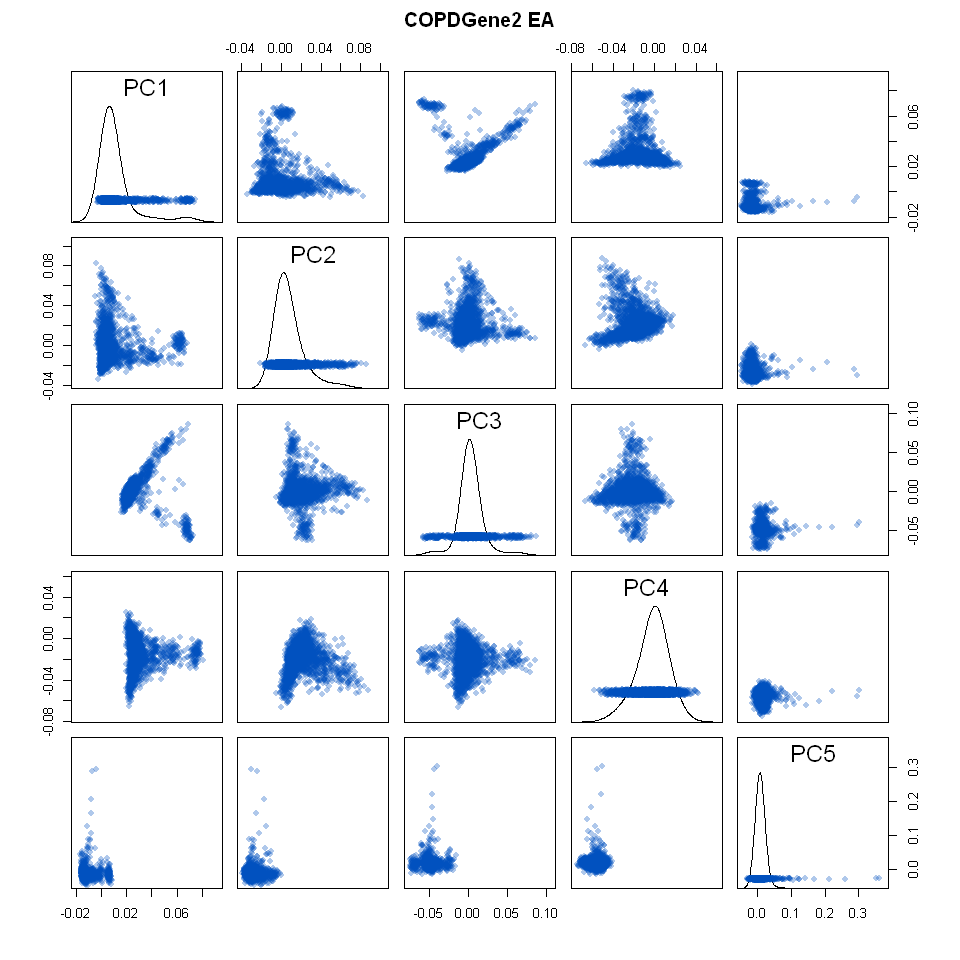

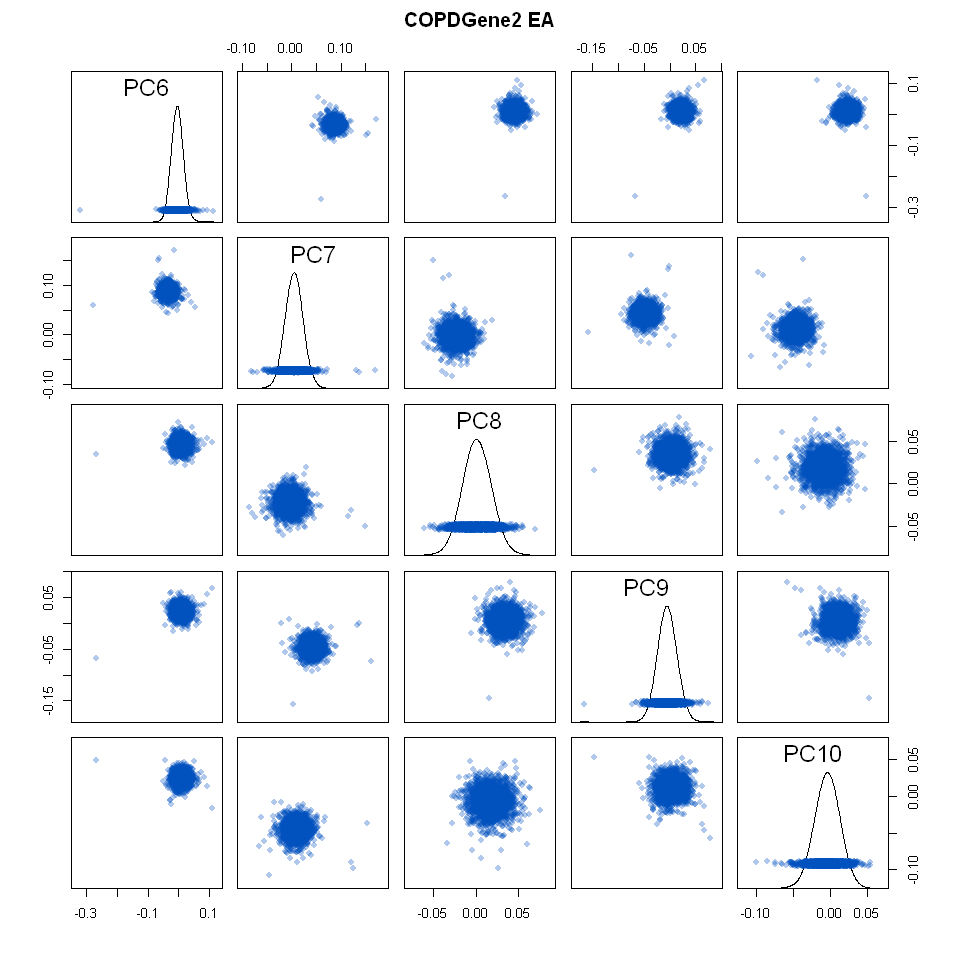

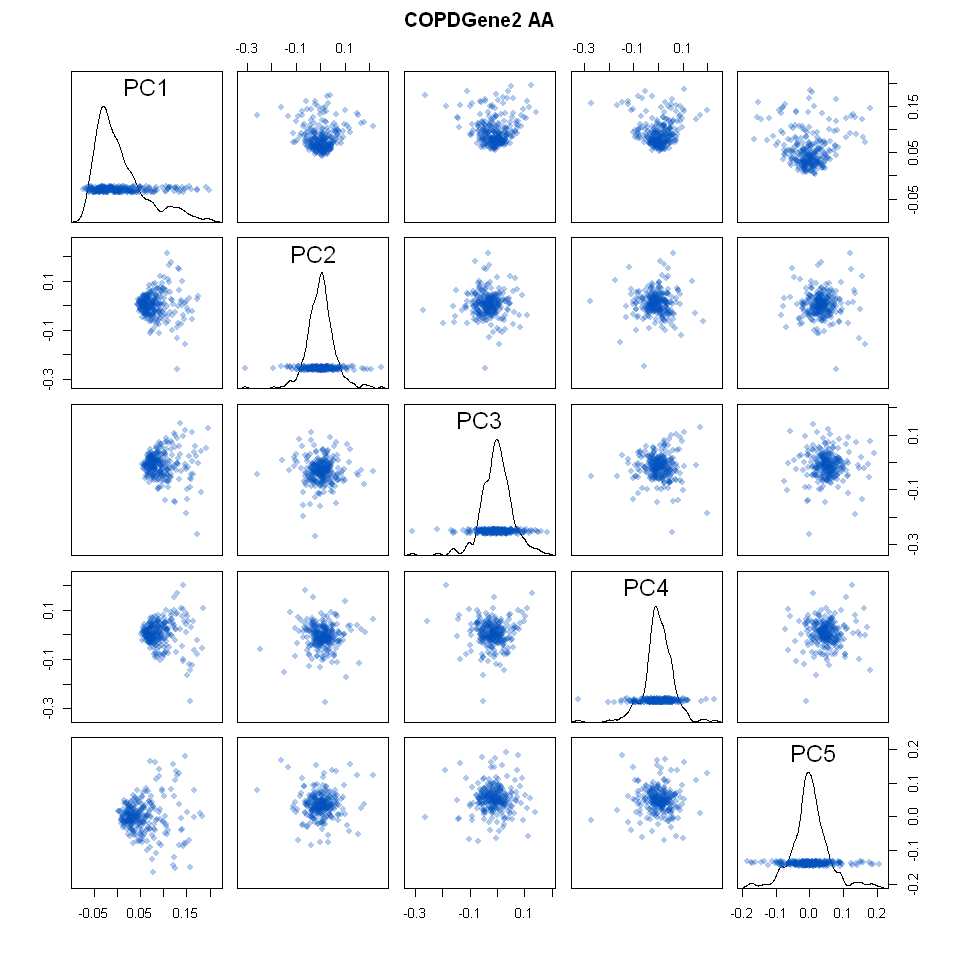

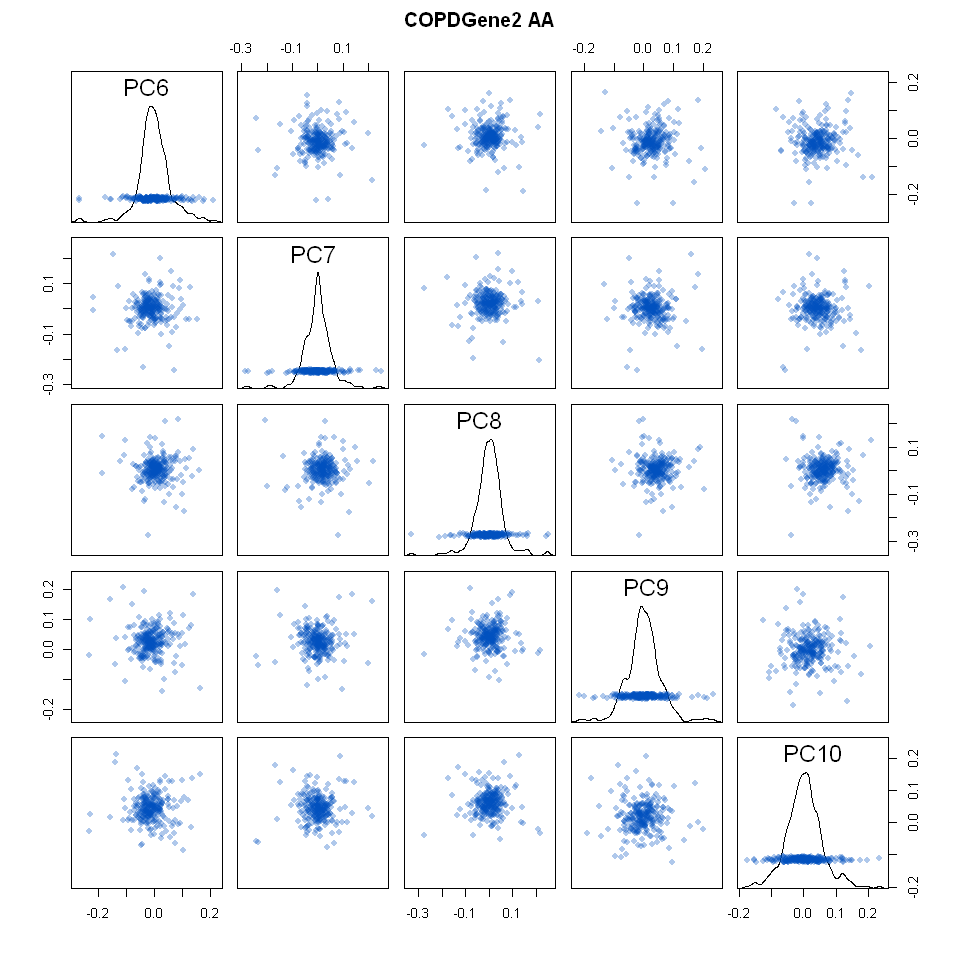

In [5]:
### R console ###

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance/
ea.dspace <- ea.evec[1:10] #transformed dataspace
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene2 EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene2 EA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene2 AA", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="COPDGene2 AA", cex.main=1)

#### Extract eigenvectors

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/eigenstrat/results

# Grab top 10 eigenvectors from PCA 
for ancestry in {"ea","aa"}; do
    # Extract eigenvectors
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 ${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> ${ancestry}_ld_pruned_top10_eigenvecs.txt
done

### EA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

**Note**: we will perform this on our local machine for convenience.

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene2/eigenstrat/results/ea_ld_pruned_top10_eigenvecs.txt .
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/copdgene2/eigenstrat/results/aa_ld_pruned_top10_eigenvecs.txt .

#### Create PED files 
The covariates we want to include are `sex`,`age`, and `gold status` and some of the most influential PCs. Sex is encoded as 1=Male and 2=Female in these phenotype data. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain $\sim75\%$ of the variance.

In [ ]:
# split phenotype file up by race
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno

head -n 1 phenotype.ftnd.fg.sex.age3.filtered.txt > ea.phenotype.data
# if the subject has a "1" for race then they are EA
awk 'NR>=2 {if ($3==1) {print $0}}' phenotype.ftnd.fg.sex.age3.filtered.txt >> ea.phenotype.data

In [7]:
### R (local) ###

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno")
p.data.ea <- "ea.phenotype.data"
pheno.data.ea <- read.csv(p.data.ea, sep = " ", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer","double",
                                    "integer","integer","integer", "integer"))
head(pheno.data.ea)
pca.data.ea <- read.csv("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat/ea_ld_pruned_top10_eigenvecs.txt",
                        sep = " " , header = T, 
                        colClasses=c(rep("character",times=2), rep("double",times = 10)))
head(pca.data.ea)

num.subjects.ea <- length(pca.data.ea[,1])

header.names <- c("fid", "iid", "patid", "matid", "sex", "age", "goldneg1", "gold1or2", "gold3or4", "ftnd")
ped.file.ea <- data.frame(matrix(ncol = length(header.names), nrow = num.subjects.ea))
colnames(ped.file.ea) <- header.names
ped.file.ea[,1] <- pca.data.ea[,1]
ped.file.ea[,2] <- pca.data.ea[,1] # will the iid be the same as the fid?

# map loop (goal to fill in sex, age, ftnd, and gold status data on ped.file from the pheno.data)
for (i in 1:num.subjects.ea){
    key <- noquote(ped.file.ea[i,2])
    
    my_match <- match(key, pheno.data.ea[,1])
    ped.file.ea[i,5] <- pheno.data.ea[my_match,2]# sex
    ped.file.ea[i,6] <- pheno.data.ea[my_match,4] # age
    ped.file.ea[i,7] <- pheno.data.ea[my_match,6] # goldneg1
    ped.file.ea[i,8] <- pheno.data.ea[my_match,7] # gold1or2
    ped.file.ea[i,9] <- pheno.data.ea[my_match,8] # gold3or4
    ped.file.ea[i,10] <- pheno.data.ea[my_match,5] # ftnd
    
} # end i loop
head(ped.file.ea)

write.table(ped.file.ea, "COPDGene2_EUR_phen.ped", sep = "\t", row.names = F, quote=F)

#----------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude ftnd data)
col.names.ea <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "goldneg1", "gold1or2", "gold3or4", "PC1", "PC2",
                  "PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.ea <- length(col.names.ea)
covar.data.ea <- data.frame(matrix(ncol = num.columns.ea, nrow = num.subjects.ea))
names(covar.data.ea) <- col.names.ea
num.covs.ea <- length(ped.file.ea) - 1
covar.data.ea[,1:num.covs.ea] <- ped.file.ea[,1:num.covs.ea]

covar.data.ea[,(num.covs.ea+1):length(col.names.ea)] <- pca.data.ea[,3:length(pca.data.ea)]

head(covar.data.ea)
print("Number of EA subjects.")
length(covar.data.ea[,1])

write.table(covar.data.ea, "COPDGene2_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

sid,gender,race,age_p1,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
10161E,1,1,73.8,2,1,0,0
10260G,1,1,68.4,1,1,0,0
10489M,2,1,60.0,1,1,0,0
10511F,2,1,80.6,0,1,0,0
10558F,1,1,60.9,1,1,0,0
10771F,1,1,69.9,0,1,0,0


FID,IID,EV1,EV2,EV3,EV4,EV5,EV6,EV7,EV8,EV9,EV10
10002K,10002K,0.0107,-0.0095,-0.0255,-0.0399,-0.0182,0.0247,0.0011,0.0020,0.0042,-0.0065
10006S,10006S,-0.0020,-0.0053,0.0016,0.0034,-0.0056,0.0173,0.0077,-0.0075,-0.0103,0.0074
10011L,10011L,-0.0128,0.0966,0.0022,-0.0437,0.0001,0.0021,-0.0081,-0.0284,-0.0147,-0.0053
10013P,10013P,-0.0072,-0.0161,-0.0042,0.0108,0.0103,0.0048,0.0211,-0.0063,0.0117,-0.0245
10015T,10015T,-0.0102,-0.0232,-0.0126,-0.0117,0.0084,0.0023,0.0251,-0.0097,0.0020,0.0042
10017X,10017X,-0.0058,-0.0142,-0.0079,0.0080,-0.0113,0.0051,-0.0189,-0.0081,0.0094,0.0039


fid,iid,patid,matid,sex,age,goldneg1,gold1or2,gold3or4,ftnd
10002K,10002K,NA,NA,2,63.6,0,0,1,2
10006S,10006S,NA,NA,2,62.3,0,1,0,0
10011L,10011L,NA,NA,2,69.7,0,1,0,0
10013P,10013P,NA,NA,2,73.4,0,1,0,0
10015T,10015T,NA,NA,1,59.6,0,0,1,1
10017X,10017X,NA,NA,1,67.5,0,1,0,2


fid,iid,patid,matid,sex,age,goldneg1,gold1or2,gold3or4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
10002K,10002K,NA,NA,2,63.6,0,0,1,0.0107,-0.0095,-0.0255,-0.0399,-0.0182,0.0247,0.0011,0.0020,0.0042,-0.0065
10006S,10006S,NA,NA,2,62.3,0,1,0,-0.0020,-0.0053,0.0016,0.0034,-0.0056,0.0173,0.0077,-0.0075,-0.0103,0.0074
10011L,10011L,NA,NA,2,69.7,0,1,0,-0.0128,0.0966,0.0022,-0.0437,0.0001,0.0021,-0.0081,-0.0284,-0.0147,-0.0053
10013P,10013P,NA,NA,2,73.4,0,1,0,-0.0072,-0.0161,-0.0042,0.0108,0.0103,0.0048,0.0211,-0.0063,0.0117,-0.0245
10015T,10015T,NA,NA,1,59.6,0,0,1,-0.0102,-0.0232,-0.0126,-0.0117,0.0084,0.0023,0.0251,-0.0097,0.0020,0.0042
10017X,10017X,NA,NA,1,67.5,0,1,0,-0.0058,-0.0142,-0.0079,0.0080,-0.0113,0.0051,-0.0189,-0.0081,0.0094,0.0039


[1] "Number of EA subjects."


[1] 2630

In [8]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno')
options(stringsAsFactors=F)
ea.cov.data <- read.delim("COPDGene2_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("COPDGene2_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "ftnd"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(ea.data)

iid,ftnd,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
10002K,2,0.0107,-0.0095,-0.0255,-0.0399,-0.0182,0.0247,0.0011,0.0020,0.0042,-0.0065
10006S,0,-0.0020,-0.0053,0.0016,0.0034,-0.0056,0.0173,0.0077,-0.0075,-0.0103,0.0074
10011L,0,-0.0128,0.0966,0.0022,-0.0437,0.0001,0.0021,-0.0081,-0.0284,-0.0147,-0.0053
10013P,0,-0.0072,-0.0161,-0.0042,0.0108,0.0103,0.0048,0.0211,-0.0063,0.0117,-0.0245
10015T,1,-0.0102,-0.0232,-0.0126,-0.0117,0.0084,0.0023,0.0251,-0.0097,0.0020,0.0042
10017X,2,-0.0058,-0.0142,-0.0079,0.0080,-0.0113,0.0051,-0.0189,-0.0081,0.0094,0.0039


#### Regression analysis
We use a regression model of the general structure $$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [9]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 ftnd ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0155 -0.7951  0.1536  0.2251  1.2935 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.82814    0.01412  58.649   <2e-16 ***
PC1         -0.50228    0.72413  -0.694   0.4880    
PC2         -1.45078    0.72416  -2.003   0.0452 *  
PC3         -0.22089    0.72413  -0.305   0.7604    
PC4         -1.85548    0.72413  -2.562   0.0105 *  
PC5          0.87524    0.72412   1.209   0.2269    
PC6          0.43511    0.72411   0.601   0.5480    
PC7          0.06082    0.72414   0.084   0.9331    
PC8          0.26075    0.72412   0.360   0.7188    
PC9          0.18027    0.72409   0.249   0.8034    
PC10         0.28135    0.72418   0.389   0.6977    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7241 on 2619 degrees of freedom
Multiple R-squared:  0.005062,	Adjusted R-squared:  0.001263 
F-stati

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC4,1,3.443208113,3.443208113,6.566345839,0.01044796,49.28
PC2,1,2.104548589,2.104548589,4.013464599,0.04524116,30.12
PC5,1,0.766099885,0.766099885,1.460985403,0.22688251,10.96
PC1,1,0.252224540,0.252224540,0.481003037,0.48802984,3.61
PC6,1,0.189345036,0.189345036,0.361089121,0.54795399,2.71
PC10,1,0.079147133,0.079147133,0.150936985,0.69767312,1.13
PC8,1,0.067991331,0.067991331,0.129662390,0.71881138,0.97
PC3,1,0.048759279,0.048759279,0.092986041,0.76043903,0.70
PC9,1,0.032494532,0.032494532,0.061968469,0.80343084,0.47
PC7,1,0.003699346,0.003699346,0.007054812,0.93306847,0.05


#### Percent Variance Explained Visualization

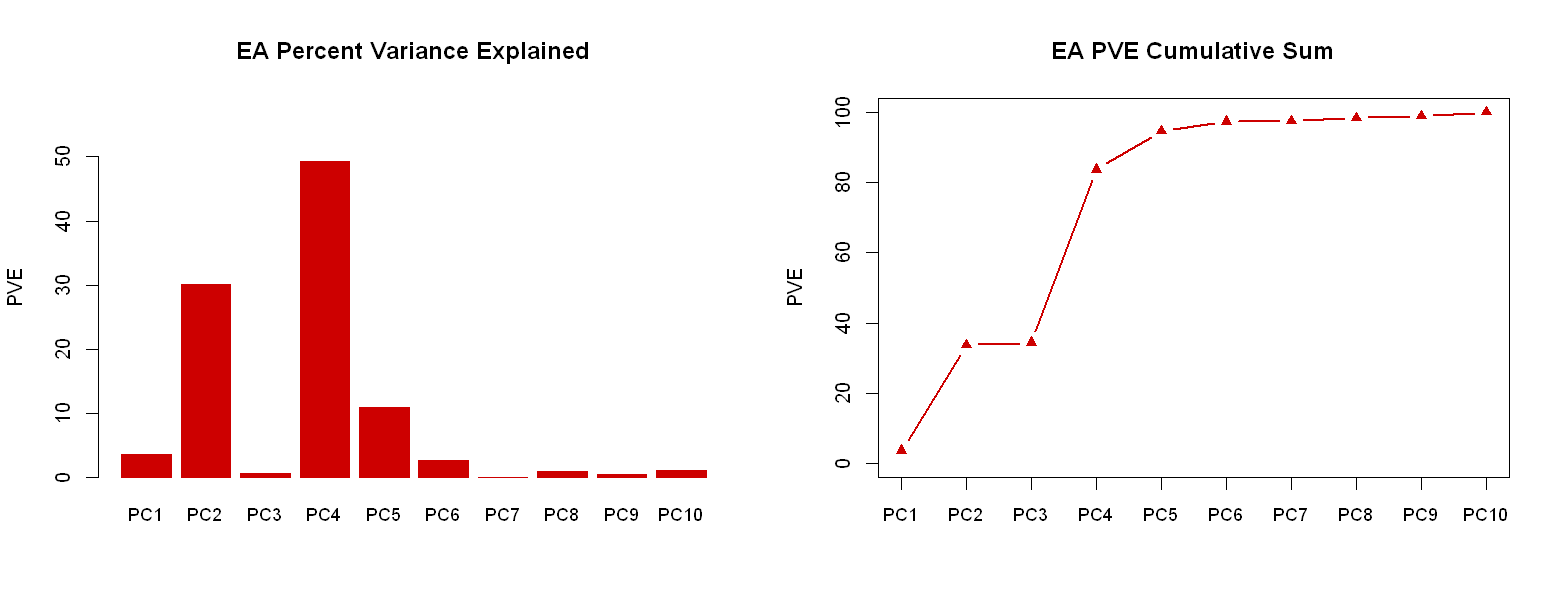

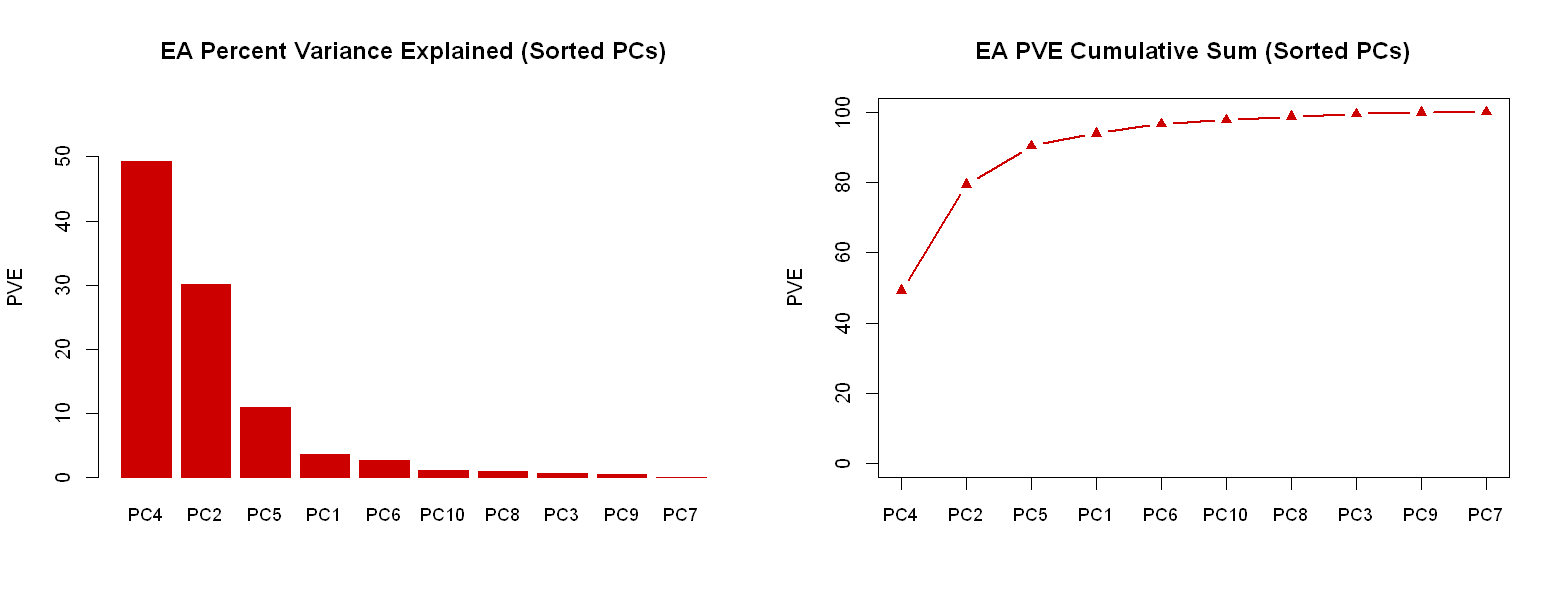

In [10]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC4, and PC2. These PCs explain ~79% of the variance.

#### Construct a phenotype file for ProbABEL with PCs
* Need to include PC4, & PC2.
* Header needs to be

```
II3     CAT_FTND      SEX     EV4     EV2        
```

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno/

# the IID in the phenotype file needs to be of the form "iid"
# to match the iid in the mldose file
ancestry=ea
awk 'BEGIN{} NR>=2{print $1}' COPDGene2_EUR_cov.ped > IID.${ancestry}.txt

In [11]:
### R console ###
setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno")

# read in data files
phen <- read.table("COPDGene2_EUR_phen.ped", header=T)
cov <- read.table("COPDGene2_EUR_cov.ped", header=T)
iid <- read.table("IID.ea.txt", header=F)
num.subjects <- length(iid[,1])
num.subjects

# create data frame to combine those files
covar.names <- c("IID", "CAT_FTND", "SEX", "AGE", "GOLDNEG1", 
                       "GOLD1OR2", "GOLD3OR4", "EV4", "EV2")
covar.data <- data.frame(matrix(ncol = length(covar.names), nrow = num.subjects))
names(covar.data) <- covar.names
covar.data[1] <- iid[1]
covar.data[2] <- phen[10]
covar.data[3] <- phen[5]
covar.data[4] <- phen[6]
covar.data[5] <- phen[7]
covar.data[6] <- phen[8]
covar.data[7] <- phen[9]
# PCs
covar.data[8] <- cov[13]
covar.data[9] <- cov[11]
head(covar.data)

write.table(x = covar.data, file = "copdgene2.ea.CAT_FTND.SEX.AGE.GOLD.EVs", quote = F, row.names = F)

[1] 2630

IID,CAT_FTND,SEX,AGE,GOLDNEG1,GOLD1OR2,GOLD3OR4,EV4,EV2
10002K,2,2,63.6,0,0,1,-0.0399,-0.0095
10006S,0,2,62.3,0,1,0,0.0034,-0.0053
10011L,0,2,69.7,0,1,0,-0.0437,0.0966
10013P,0,2,73.4,0,1,0,0.0108,-0.0161
10015T,1,1,59.6,0,0,1,-0.0117,-0.0232
10017X,2,1,67.5,0,1,0,0.0080,-0.0142


### AA PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

**Note**: we will perform this on our local machine for convenience.

#### Create PED files 
The covariates we want to include are `sex`,`age`, and `gold status` and some of the most influential PCs. Sex is encoded as 1=Male and 2=Female in these phenotype data. Here we create the `phen` and `cov` PED files so that downstream processing will be easier. Specifically, creating the PED files will make it easier to select the PCs that explain $\sim75\%$ of the variance.

In [ ]:
## local console  ##
# split phenotype file up by race
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno

head -n 1 phenotype.ftnd.fg.sex.age3.filtered.txt > aa.phenotype.data
awk 'NR>=2 {if ($3==2) {print $0}}' phenotype.ftnd.fg.sex.age3.filtered.txt >> aa.phenotype.data

In [14]:
### R (local) ###

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno")
p.data.aa <- "aa.phenotype.data"
pheno.data.aa <- read.csv(p.data.aa, sep = " ", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer","double",
                                    "integer","integer","integer", "integer"))
head(pheno.data.aa)
pca.data.aa <- read.csv("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/eigenstrat/aa_ld_pruned_top10_eigenvecs.txt", sep = " " , 
                    colClasses=c(rep("character",times=2), rep("double",times = 10)))
head(pca.data.aa)

num.subjects.aa <- length(pca.data.aa[,1])

header.names <- c("fid", "iid", "patid", "matid", "sex", "age", "goldneg1", "gold1or2", "gold3or4", "ftnd")
ped.file.aa <- data.frame(matrix(ncol = length(header.names), nrow = num.subjects.aa))
colnames(ped.file.aa) <- header.names
ped.file.aa[,1] <- pca.data.aa[,1]
ped.file.aa[,2] <- pca.data.aa[,1] # will the iid be the same as the fid?

# map loop (goal to fill in sex, age, ftnd, and gold status data on ped.file from the pheno.data)
for (i in 1:num.subjects.aa){
    key <- noquote(ped.file.aa[i,2])
    
    my_match <- match(key, pheno.data.aa[,1])
    ped.file.aa[i,5] <- pheno.data.aa[my_match,2]# sex
    ped.file.aa[i,6] <- pheno.data.aa[my_match,4] # age
    ped.file.aa[i,7] <- pheno.data.aa[my_match,6] # goldneg1
    ped.file.aa[i,8] <- pheno.data.aa[my_match,7] # gold1or2
    ped.file.aa[i,9] <- pheno.data.aa[my_match,8] # gold3or4
    ped.file.aa[i,10] <- pheno.data.aa[my_match,5] # ftnd
    
} # end i loop
head(ped.file.aa)
#
write.table(ped.file.aa, "COPDGene2_AA_phen.ped", sep = "\t", row.names = F, quote=F)
#
##----------------------------------------------------------------------------------
### Cov file

# 10 PCs plus all of the covariates (exclude ftnd data)
col.names.aa <- c("fid", "iid", "patid", "matid", "sex", "age",
                  "goldneg1", "gold1or2", "gold3or4", "PC1", "PC2",
                  "PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
num.columns.aa <- length(col.names.aa)
covar.data.aa <- data.frame(matrix(ncol = num.columns.aa, nrow = num.subjects.aa))
names(covar.data.aa) <- col.names.aa
num.covs.aa <- length(ped.file.aa) - 1
covar.data.aa[,1:num.covs.aa] <- ped.file.aa[,1:num.covs.aa]

covar.data.aa[,(num.covs.aa+1):length(covar.data.aa)] <- pca.data.aa[,3:length(pca.data.aa)]
head(covar.data.aa)
print("Number of AA subjects.")
length(covar.data.aa[,1])

write.table(covar.data.aa, "COPDGene2_AA_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

sid,gender,race,age_p1,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
11941J,2,2,45.1,0,1,0,0
12089G,1,2,53.1,1,1,0,0
12110X,1,2,57.1,0,1,0,0
12343U,2,2,56.5,0,1,0,0
12430P,1,2,53.6,1,1,0,0
12956B,2,2,53.8,0,1,0,0


FID,IID,EV1,EV2,EV3,EV4,EV5,EV6,EV7,EV8,EV9,EV10
10012N,10012N,0.1217,0.1753,-0.0110,0.0587,0.1480,0.0932,0.1755,0.0442,0.0365,0.1245
10025W,10025W,0.0691,-0.0823,-0.0230,0.0342,0.0896,0.0136,0.0679,0.0100,0.0064,-0.1178
10049K,10049K,-0.0402,-0.0018,0.0112,-0.0180,0.0249,-0.0488,-0.0091,-0.0119,0.0129,-0.0513
10055F,10055F,-0.0147,-0.0788,-0.0606,-0.0010,0.0202,-0.0202,0.0014,-0.0151,-0.0063,-0.0472
10217F,10217F,0.0179,-0.0049,0.0085,-0.1169,0.0004,-0.0109,0.1307,0.0223,-0.0060,0.0040
10303Y,10303Y,-0.0490,-0.0352,0.0074,0.0227,0.0035,0.0148,0.0039,0.0123,0.0813,-0.0063


fid,iid,patid,matid,sex,age,goldneg1,gold1or2,gold3or4,ftnd
10012N,10012N,NA,NA,2,60.8,0,0,1,2
10025W,10025W,NA,NA,1,68.9,0,0,1,0
10049K,10049K,NA,NA,1,49.9,0,1,0,1
10055F,10055F,NA,NA,1,69.0,0,0,0,1
10217F,10217F,NA,NA,1,49.9,0,0,0,1
10303Y,10303Y,NA,NA,1,54.1,0,0,1,0


fid,iid,patid,matid,sex,age,goldneg1,gold1or2,gold3or4,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
10012N,10012N,NA,NA,2,60.8,0,0,1,0.1217,0.1753,-0.0110,0.0587,0.1480,0.0932,0.1755,0.0442,0.0365,0.1245
10025W,10025W,NA,NA,1,68.9,0,0,1,0.0691,-0.0823,-0.0230,0.0342,0.0896,0.0136,0.0679,0.0100,0.0064,-0.1178
10049K,10049K,NA,NA,1,49.9,0,1,0,-0.0402,-0.0018,0.0112,-0.0180,0.0249,-0.0488,-0.0091,-0.0119,0.0129,-0.0513
10055F,10055F,NA,NA,1,69.0,0,0,0,-0.0147,-0.0788,-0.0606,-0.0010,0.0202,-0.0202,0.0014,-0.0151,-0.0063,-0.0472
10217F,10217F,NA,NA,1,49.9,0,0,0,0.0179,-0.0049,0.0085,-0.1169,0.0004,-0.0109,0.1307,0.0223,-0.0060,0.0040
10303Y,10303Y,NA,NA,1,54.1,0,0,1,-0.0490,-0.0352,0.0074,0.0227,0.0035,0.0148,0.0039,0.0123,0.0813,-0.0063


[1] "Number of AA subjects."


[1] 267

In [16]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno/')
options(stringsAsFactors=F)
aa.cov.data <- read.delim("COPDGene2_AA_cov.ped", header=T, sep="\t")
aa.phen.data <- read.delim("COPDGene2_AA_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "ftnd"
pc.names <- paste0("PC", 1:10)
aa.data <- merge(x=aa.phen.data[,c("iid",phen.name)], y=aa.cov.data[, c("iid", paste0("PC",1:10))], by="iid")
head(aa.data)

iid,ftnd,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
10012N,2,0.1217,0.1753,-0.0110,0.0587,0.1480,0.0932,0.1755,0.0442,0.0365,0.1245
10025W,0,0.0691,-0.0823,-0.0230,0.0342,0.0896,0.0136,0.0679,0.0100,0.0064,-0.1178
10049K,1,-0.0402,-0.0018,0.0112,-0.0180,0.0249,-0.0488,-0.0091,-0.0119,0.0129,-0.0513
10055F,1,-0.0147,-0.0788,-0.0606,-0.0010,0.0202,-0.0202,0.0014,-0.0151,-0.0063,-0.0472
10217F,1,0.0179,-0.0049,0.0085,-0.1169,0.0004,-0.0109,0.1307,0.0223,-0.0060,0.0040
10303Y,0,-0.0490,-0.0352,0.0074,0.0227,0.0035,0.0148,0.0039,0.0123,0.0813,-0.0063


#### Regression analysis
We use a regression model of the general structure $$\begin{align}
\text{FTND = PC1 + PC2 + ... + PC10}
\end{align}$$

In [17]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.aa <- lm(formula=as.formula(model.str), data=aa.data)

# Get sequential (type I) sum of squares
anova.aa <- anova(lm.fit.aa)

# Calculate percent variance explained and sort
aa.pve <- cbind(anova.aa[pc.names,], 
                PVE=round(anova.aa[pc.names, "Mean Sq"]/sum(anova.aa[pc.names, "Mean Sq"])*100, digits=2))
aa.pve.sorted <- aa.pve[order(aa.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ AA group ================")
summary(lm.fit.aa)
aa.pve.sorted

MODEL FORMULA:

 ftnd ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AA group ================


Call:
lm(formula = as.formula(model.str), data = aa.data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.8033 -0.5227 -0.4175  0.4749  1.6598 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.52060    0.03852  13.515   <2e-16 ***
PC1         -0.01856    0.62940  -0.029    0.976    
PC2         -0.50035    0.62939  -0.795    0.427    
PC3          0.10076    0.62939   0.160    0.873    
PC4          0.10583    0.62939   0.168    0.867    
PC5         -0.04439    0.62941  -0.071    0.944    
PC6         -0.54616    0.62938  -0.868    0.386    
PC7          0.26453    0.62941   0.420    0.675    
PC8         -0.20947    0.62940  -0.333    0.740    
PC9          0.26400    0.62940   0.419    0.675    
PC10        -0.68136    0.62946  -1.082    0.280    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6294 on 256 degrees of freedom
Multiple R-squared:  0.01189,	Adjusted R-squared:  -0.02671 
F-statist

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC10,1,0.4641830577,0.4641830577,1.1717096066,0.2800688,38.05
PC6,1,0.2982782100,0.2982782100,0.7529258948,0.3863641,24.45
PC2,1,0.2503860205,0.2503860205,0.6320344974,0.4273465,20.52
PC7,1,0.0699646452,0.0699646452,0.1766075808,0.6746575,5.73
PC9,1,0.0696747659,0.0696747659,0.1758758558,0.6752934,5.71
PC8,1,0.0438778697,0.0438778697,0.1107582893,0.7395549,3.60
PC4,1,0.0112057546,0.0112057546,0.0282860180,0.8665709,0.92
PC3,1,0.0101669454,0.0101669454,0.0256638138,0.8728504,0.83
PC5,1,0.0019732463,0.0019732463,0.0049809478,0.9437904,0.16
PC1,1,0.0003438556,0.0003438556,0.0008679742,0.9765196,0.03


#### Percent Variance Explained Visualization

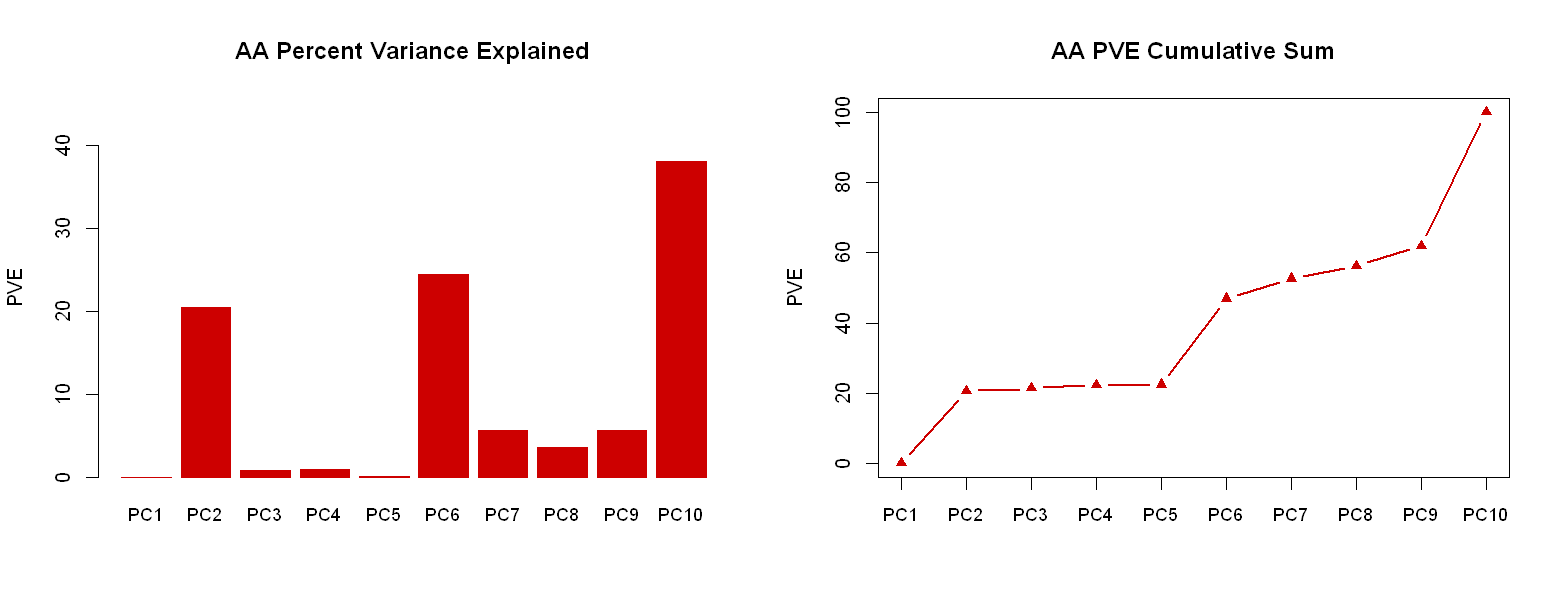

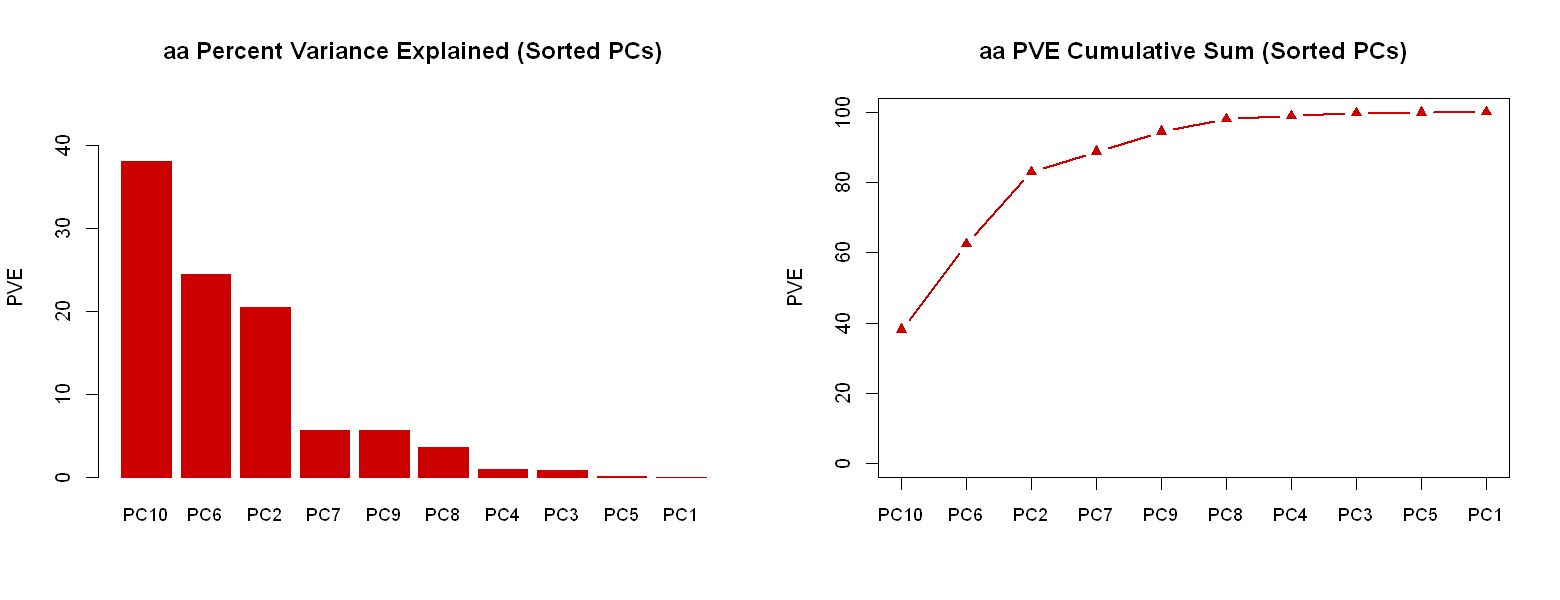

In [18]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.aa = c(0, max(aa.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=aa.pve$PVE, names.arg=rownames(aa.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, 
        main="AA Percent Variance Explained", ylab="PVE")
plot(cumsum(aa.pve$PVE), type="b", main="AA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=aa.pve.sorted$PVE, names.arg=rownames(aa.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.aa, main="aa Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(aa.pve.sorted$PVE), type="b", main="aa PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(aa.pve.sorted), cex.axis=cex.factor)

Based on these results we will use PC10, PC6, and PC2. These PCs explain ~84% of the variance.

#### Construct a phenotype file for ProbABEL with PCs
* Need to include PC10, PC6, & PC2.
* Header needs to be

```
IID     CAT_FTND      SEX     EV10     EV6     EV2
```

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno

# the IID in the phenotype file needs to be of the form "iid"
# to match the iid in the mldose file
awk 'BEGIN{} NR>=2{print $1}' COPDGene2_AA_cov.ped > IID.aa.txt

In [21]:
### R console ###
setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno")

# read in data files
phen <- read.table("COPDGene2_AA_phen.ped", header=T)
cov <- read.table("COPDGene2_AA_cov.ped", header=T)
iid <- read.table("IID.aa.txt", header=F)
num.subjects <- length(iid[,1])
print("Number of AA subjects.")
num.subjects

# create data frame to combine those files
covar.names <- c("IID", "CAT_FTND", "SEX", "AGE", "GOLDNEG1", 
                       "GOLD1OR2", "GOLD3OR4", "EV10", "EV6", "EV2")
covar.data <- data.frame(matrix(ncol = length(covar.names), nrow = num.subjects))
names(covar.data) <- covar.names
covar.data[1] <- iid[1]
covar.data[2] <- phen[10]
covar.data[3] <- phen[5]
covar.data[4] <- phen[6]
covar.data[5] <- phen[7]
covar.data[6] <- phen[8]
covar.data[7] <- phen[9]
# PCs 
covar.data[8] <- cov[19]
covar.data[9] <- cov[15]
covar.data[10] <- cov[11]
head(covar.data)

write.table(x = covar.data, file = "copdgene2.aa.CAT_FTND.SEX.AGE.GOLD.EVs", quote = F, row.names = F)

[1] "Number of AA subjects."


[1] 267

IID,CAT_FTND,SEX,AGE,GOLDNEG1,GOLD1OR2,GOLD3OR4,EV10,EV6,EV2
10012N,2,2,60.8,0,0,1,0.1245,0.0932,0.1753
10025W,0,1,68.9,0,0,1,-0.1178,0.0136,-0.0823
10049K,1,1,49.9,0,1,0,-0.0513,-0.0488,-0.0018
10055F,1,1,69.0,0,0,0,-0.0472,-0.0202,-0.0788
10217F,1,1,49.9,0,0,0,0.0040,-0.0109,-0.0049
10303Y,0,1,54.1,0,0,1,-0.0063,0.0148,-0.0352


### Transfer Phenotype Files 
This analysis is going to be performed on MIDAS. We will therefore have to transfer these EA and AA phenotype files that we created.

In [ ]:
## MIDAS ##
# create directory structure on MIDAS
mkdir -p /share/nas04/jmarks/gwas/copdgene2/{association_tests/001,phenotype}

In [ ]:
## local command line ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/pheno

scp copdgene2.* jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene2/phenotype/

## Genotype Data COPDGene2
The genotype data have been imputed on the in-house computing cluster MIDAS using impute2. IMPUTE2 is a computer program for phasing observed genotypes and imputing missing genotypes

The imputed data are split by chromosome and the chromosome data are further split into chunks. Because of this, we will incorporate the Nextflow pipeline that has already been established. 

# ProbABEL Analysis with Nextflow
We try out ProbABEL as integrated into [Nextflow](https://www.nextflow.io/). Nextflow allows you to write a computational pipeline by making it simpler to put together many different tasks. 

* For the analysis, I will need the script: `_pipeline.association.out_stats_files.run.sh` and `nextflow.config`.

* To generate the plots I will need: `_methods.cogend.imputed.v3.association_tests.006.sh`

These scripts were copied to my working directory from an example directory on MIDAS at the location:

`/share/nas04/bioinformatics_group/data/studies/jhs_aric_aa/imputed/v3/association_tests/001`

## Scripts to run analysis
These scripts should be placed in the working directory. For this analysis on MIDAS, the working directory they were placed in was `/share/nas04/jmarks/gwas/copdgene2/associtation_tests/001`

To run the analysis, simply `cd` into working directory and run the command:
`sh _pipeline.association.out_stats_files.run.sh`

#### pipeline script

In [ ]:
#!/bin/sh

for ancestry in {ea,aa}; do
    working_dir=/share/nas04/jmarks/gwas/copdgene2/association_tests/001/${ancestry}
    imputation_root=/share/nas03/bioinformatics_group/data/studies/copdgene/imputed/v3/imputations
    # path to phenotype file created in the section above
    phenotype_root=/share/nas04/jmarks/gwas/copdgene2/phenotype 

    method=palinear # GWAS method

    for (( chr=1; chr<24; chr++ )); do
        out_file=copdgene2.${ancestry}.1000G_p3.chr$chr.CAT_FTND~SNP+AGE+SEX+EVs.stats
        phenotype_file=copdgene2.${ancestry}.CAT_FTND.SEX.AGE.GOLD.EVs
        geno_prefix=copdgene.${ancestry}.1000G_p3.chr

        /share/nas03/bioinformatics_group/software/nextflow/nextflow-0.25.1-all \
        /share/nas03/bioinformatics_group/software/pipeline/_pipeline.association.out_stats_files.v0.1.nf \
            --final_chunks $imputation_root/chunks/final_chunks.chr$chr \
            --input_pheno $phenotype_root/$phenotype_file \
            --imputation_dir $imputation_root/${ancestry}/chr$chr \
            --example_mldose $imputation_root/${ancestry}/chr$chr/copdgene.${ancestry}.1000G_p3.chr$chr.2.mach.mldose.gz \
            --geno_prefix $geno_prefix \
            --working_dirs $working_dir \
            --out ${working_dir}/$out_file \
            --method $method

        rm -r $working_dir/../work
    done
done

#### nextflow.config

In [ ]:
## MIDAS ##
cd /share/nas04/jmarks/gwas/copdgene2/associtation_tests/001/

cat nextflow.config
"""
process.executor = 'sge'
process.clusterOptions = '-S /bin/bash'
"""

### Error message

In [ ]:
""" Reading info data...
  Number of SNPs = 113721
  Reading phenotype data...
  Actual number of people in phenofile = 2630; using all of these
  Linear model: ( CAT_FTND ) ~ mu + SEX + AGE + GOLDNEG1 + GOLD1OR2 + GOLD3OR4 + EV4 + EV2 + SNP_A1
  Reading genotype data...

Command error:
  No digits were found while reading genetic data (individual 2324, position 113693)

Work dir:
  /share/nas04/jmarks/gwas/copdgene2/association_tests/001/work/19/1096cdaa311714371967a9edea6c3d
"""

# Filter Results and Plot
This scripts should be placed in the working directory. For this analysis on MIDAS, the working directory they were placed in was `/share/nas04/jmarks/gwas/copdgene2/association_tests/001`.

We will apply the filters
* MAF > 0.01
* and Rsq > 0.3

to the results of the GWAS analysis. Once the results are filtered, we will generate a [quantile-quantile (QQ) plot](https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm) as well as a [Manhattan plot](https://www.sciencedirect.com/topics/medicine-and-dentistry/manhattan-plot).

**Note**: The script below should be modified for each cohort and/or ancestry group. For example:
* line 2 and line 194 should be changed to copdgene2 for that cohort
*  if running for both ancestry groups line 7 should be commented out while, line 6, 16, 29, 59, 66, 88, 110, 133, 172, 192,  should be uncommented out
* uncomment all of the end-loop *done* expressions that correspond to the above bullet-point example

Also note this is the legacy script designed for execution on the in-house MIDAS cluster. The paths should be modified as necessary for computing on different computing platforms.

In [ ]:
ASSOCIATION_ROOT=/share/nas04/jmarks/gwas/copdgene2/association_tests/001
COHORT=copdgene2
MODEL=CAT_FTND~SNP+AGE+SEX+GOLD+EVs

# making directories to process the results
#for ancestry in {ea,aa}; do
ancestry=aa
    for (( chr=1; chr<24; chr++ )); do
        mkdir -p $ASSOCIATION_ROOT/$ancestry/processing/chr$chr
    done
    mkdir $ASSOCIATION_ROOT/$ancestry/final
#done
### START Filter ###

# add in chr id
#for ancestry in {ea,aa}; do

    for (( chr=1; chr<24; chr++ )); do
        inFile=$ASSOCIATION_ROOT/$ancestry/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats
        echo Processing $inFile
        outFile=$ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats
        echo -e "chr\tname\tposition\tA1\tA2\tFreq1\tMAF\tQuality\tRsq\tn\tMean_predictor_allele\tbeta_SNP_add\tsebeta_SNP_add\tchi2_SNP\tchi\tp\tor_95_percent_ci" > $outFile
        tail -n +1 $inFile |
          perl -slne '{ print join("\t", "$chr", "$_"); }' -- -chr="$chr" >> $outFile # pass rudamentary arg
    done
#done

# MAF > 0.01 in AFR (AA) or EUR (EA)
#for ancestry in {ea,aa};do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
    for (( chr=1; chr<24; chr++ )); do
      if [ $chr == "23" ]; then
        # this is a list of all of the variants that have a MAF less than 0.01. We will use this as a remove list.
        idList=/share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.maf_lte_0.01_$group
      else
        idList=/share/nas03/bioinformatics_group/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.maf_lte_0.01_$group
      fi
      /share/nas03/bioinformatics_group/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr} \
        --script_prefix $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group \
        --mem 3.8 \
        --priority 0 \
        --program /share/nas03/bioinformatics_group/software/perl/extract_rows.pl \
        --source $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --id_list $idList \
        --out $ASSOCIATION_ROOT/$ancestry/processing/chr$chr/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group \
        --header 0 \
        --id_column 1 \
        --remove
    done
#done

python /home/jmarks/monitor.py # report progress on jobs

#for ancestry in aa; do
# note the three question marks is a wildcard
  mv $ASSOCIATION_ROOT/$ancestry/processing/chr*/*.maf_gt_0.01_??? \
   $ASSOCIATION_ROOT/$ancestry/final
#done

# Filter out variants with MAF <= 0.01 in study
#for ancestry in {ea,aa}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<24; chr++ )); do
        inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$group
        outFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT
        echo Processing $inFile
        head -n 1 $inFile > $outFile
        tail -n +2 $inFile |
            # ?: is a non-capturing group. Basically, This is skipping groups 1-6 and capturing
            # the 7th column which is the MAF column
            perl -lne '/^(?:\S+\s+){6}(\S+)/;
                        if ( $1 > 0.01) {
                            print;
                        }' >> $outFile
    done
#done

# Filter out variants with Rsq <= 0.3 in study
#for ancestry in {ea,aa}; do
    if [ $ancestry == "aa" ]; then
        group=afr
    else
        group=eur
    fi
    for (( chr=1; chr<24; chr++ )); do
    inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT
    outFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_${group}+$COHORT.rsq_gt_0.3
    echo Processing $inFile
    head -n 1 $inFile > $outFile
    tail -n +2 $inFile |
        perl -lne '/^(?:\S+\s+){8}(\S+)/;
                    if ( $1 > 0.3) {
                        print;
                    }' >> $outFile
    done
#done

### END Filter ###

### START Generate plots ###
#for ancestry in aa; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
        outFile=$ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outFile
for (( chr=1; chr<24; chr++ )); do
    inFile=$ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext
    echo Processing $inFile
    tail -n +2 $inFile |
      perl -lne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){10}\s+(\S+)/;
                 if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                   print join("\t",$2,$1,$3,$6,"snp");
                 } else {
                   print join("\t",$2,$1,$3,$6,"indel");
                 }' >> $outFile
done
done
#done

#for ancestry in {ea,aa}; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
/share/nas03/bioinformatics_group/software/scripts/qsub_job.sh \
  --job_name gwas_plots \
  --script_prefix $ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.plots \
  --mem 15 \
  --priority 0 \
  --program /share/nas03/bioinformatics_group/software/R/dev/generate_gwas_plots.v6.R \
  --in $ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.table \
  --in_chromosomes autosomal_nonPAR \
  --in_header \
  --out $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext \
  --col_id VARIANT_ID \
  --col_chromosome CHR \
  --col_position POSITION \
  --col_p P \
  --col_variant_type TYPE \
  --generate_snp_indel_manhattan_plot \
  --manhattan_odd_chr_color red \
  --manhattan_even_chr_color blue \
  --manhattan_points_cex 1.5 \
  --generate_snp_indel_qq_plot \
  --qq_lines \
  --qq_points_bg black \
  --qq_lambda
done
#done

### END Generate plots ###


### START Filter by p-value ###

# MAF > 0.01 in AFR and EUR
#for ancestry in aa; do
  if [ $ancestry == "aa" ]; then
    group=afr
  else
    group=eur
  fi
  for ext in $group ${group}+$COHORT.rsq_gt_0.3; do
    outFile=$ASSOCIATION_ROOT/$ancestry/processing/$COHORT.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_$ext.p_lte_0.001
    head -n 1 $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr1.$MODEL.maf_gt_0.01_$ext > \
      $outFile
    for (( chr=1; chr<24; chr++ )); do
      echo Processing ${ASSOCIATION_ROOT}/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext
      tail -n +2 $ASSOCIATION_ROOT/$ancestry/final/$COHORT.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_$ext |
        perl -lane 'if ($F[15] <= 0.001) { print; }' >> \
        $outFile
    done
done
#done

# Sort
#for (ancestry in c("ea","aa")){
for (ancestry in c("aa")){
        cohort="copdgene2"
        if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0('/share/nas04/jmarks/gwas/',cohort, '/association_tests/001/',
                              ancestry,'/processing/', cohort, '.',ancestry,
                              '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                              group,'.p_lte_0.001'), header = TRUE)
        dat = dat[order(dat$p),]
        write.csv(dat,
            file = paste0('/share/nas04/jmarks/gwas/',cohort,'/association_tests/001/',
                          ancestry,'/final/', cohort, '.',ancestry,'.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                          group,'.p_lte_0.001.csv'), row.names = FALSE)
    
    
        dat=read.table(paste0('/share/nas04/jmarks/gwas/', cohort,'/association_tests/001/',
                              ancestry,'/processing/', cohort, '.',ancestry,
                              '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',group,
                              '+', cohort, '.rsq_gt_0.3.p_lte_0.001'), header=TRUE)
        dat = dat[order(dat$p),]
        write.csv(dat,
                  file = paste0('/share/nas04/jmarks/gwas/', cohort, '/association_tests/001/',
                         ancestry,'/final/', cohort, '.', ancestry, '.1000G_p3.CAT_FTND~SNP+AGE+SEX+GOLD+EVs.maf_gt_0.01_',
                         group,'+',cohort,'.rsq_gt_0.3.p_lte_0.001.csv'), row.names = FALSE)
}

## END Filter by p-value ###

## monitor.py
This python script was used in the above filtering/plotting script to let the user know the status of the processing jobs.

Location: `/home/jmarks/monitor.py`

In [ ]:
import subprocess
from sys import stdout, argv
from time import sleep
def check():
    p = subprocess.Popen(['qstat'], stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    out, err = p.communicate()
    return len(out.split('\n')) - 3, out

rows, msg = check()

while(rows > 0):
    stdout.write("\r%d jobs remaining..............." % rows)
    if(len(argv) > 1 and argv[1] == "show"):
        stdout.write('/n/')
        stdout.write(msg)
    stdout.flush()
    sleep(10)
    rows, msg = check()
stdout.write("\n" + "Finished.\n")

## Copy Results to Local

In [ ]:
## local console ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/results/aa/figures
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene2/association_tests/001/aa/final/*png .

cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/copdgene2/results/aa
scp jmarks@rtplhpc01.rti.ns:/share/nas04/jmarks/gwas/copdgene2/association_tests/001/aa/final/*.csv .

# Sandbox

In [ ]:
## EC2 ##
cd /shared/s3/copdgene2/association_tests

ancestry=aa
#for chr in {5,6,11}; do
chr=5
    for chunk in $(grep -P "^$chr\s+" /shared/s3/copdgene2/data/genotype/imputed/final_chunks | perl -lane 'print $F[1];'); do  

        baseName=copdgene.${ancestry}.1000G_p3.chr${chr}.${chunk}
        imputationDir=/shared/s3/copdgene2/data/genotype/imputed/$ancestry/chr$chr
        phenotypeDir=/shared/s3/copdgene2/data/phenotype
        processingDir=/shared/s3/copdgene2/association_tests
        model=CAT_FTND.SEX.AGE.GOLD.EVs
        
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name copdgene2_${chr}_$chunk \
            --script_prefix $processingDir/chr$chr/$baseName.$model \
            --mem 10 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palinear \
                --pheno $phenotypeDir/copdgene2.aa.CAT_FTND.SEX.AGE.GOLD.EVs
                --dose $imputationDir/$baseName.mach.mldose
                --info $imputationDir/$baseName.mach.mlinfo
                --map $imputationDir/$baseName.legend
                --chrom $chr
                --out $processingDir/$ancestry/$baseName.$model
    done
done


